## Modelo para testar a hipótese "Certos tipos de crime acontecem com mais frequência após o horário de expediente (depois das 17h)"

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
pd.set_option('display.max_columns', None)

In [2]:
path = os.path.abspath('../data/analise_crime_filtrado.csv')
df = pd.read_csv(path,comment='#', low_memory=False)

In [3]:
df.head(4)

,OCORRENCIA_CODIGO,NATUREZA1_DESCRICAO,NATUREZA,ATENDIMENTO_BAIRRO_NOME,REGIONAL_FATO_NOME,OCORRENCIA_ANO,OCORRENCIA_DATA,OCORRENCIA_HORA,OCORRENCIA_HORA_SEM_MINUTO,OCORRENCIA_MES,OCORRENCIA_DIA_SEMANA,OCORRENCIA_DATA_SEM_HORARIO,FERIADO,LATITUDE,LONGITUDE
0,5122.0,Roubo,ROUBO,XAXIM,BOQUEIRÃO,2009.0,2009-03-13 09:20:00.000,09:20:00,9,3.0,SEXTA,2009-03-13,0.0,-25.426683,-49.272357
1,5507.0,Atos obscenos/libidinosos,PUDOR,BAIRRO ALTO,BOA VISTA,2009.0,2009-03-19 12:05:00.000,12:05:00,12,3.0,QUINTA,2009-03-19,0.0,-25.412337,-49.205083
2,4899.0,Embriaguez,RISCO_VIDA,FAZENDINHA,PORTÃO,2009.0,2009-03-09 14:00:00.000,14:00:00,14,3.0,SEGUNDA,2009-03-09,0.0,NaN,NaN
3,5401.0,Furto,ROUBO,FAZENDINHA,PORTÃO,2009.0,2009-03-16 20:11:00.000,20:11:00,20,3.0,SEGUNDA,2009-03-16,0.0,NaN,NaN


In [4]:
nature_count = df.NATUREZA.value_counts()
nature_count

ROUBO           26839
AGRESSAO        15361
RISCO_VIDA       4382
CRIME_MULHER     3681
PUDOR            2805
SEQUESTRO         415
MORTES            141
ESTUPRO           108
EXPLORACAO         17
Name: NATUREZA, dtype: int64

In [5]:
crimes = df.NATUREZA.unique()

## Séries Temporais

<AxesSubplot:xlabel='OCORRENCIA_HORA_SEM_MINUTO'>

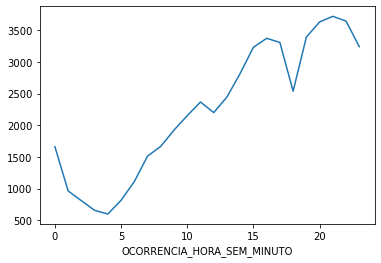

In [6]:
df.groupby('OCORRENCIA_HORA_SEM_MINUTO').size().rename('TOTAL_HORA').plot.line()

### Série temporal por tipo de crime

In [7]:
series = []
for i in crimes:
    df_crime = df.query(f"NATUREZA == '{i}'").filter(['NATUREZA', 'OCORRENCIA_HORA_SEM_MINUTO'])    
    df_crime = df_crime.groupby('OCORRENCIA_HORA_SEM_MINUTO').size()
    
    series.append(df_crime)

### Plot de todas as séries

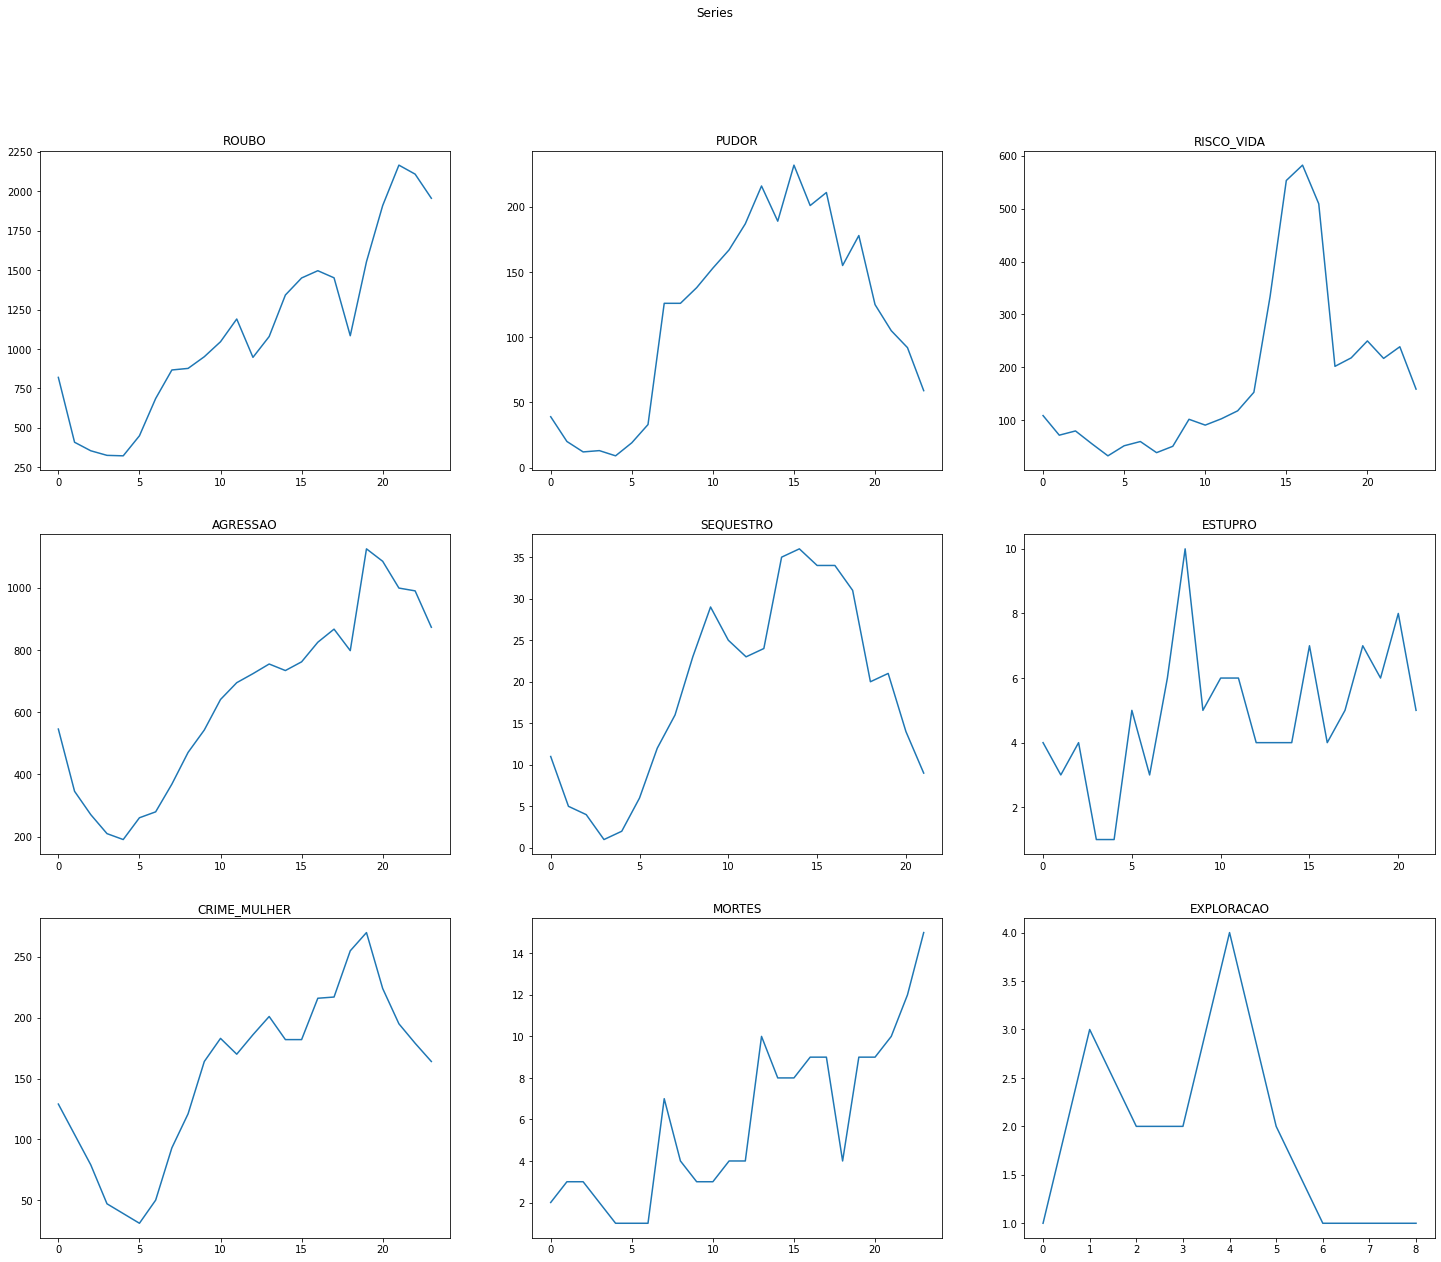

In [8]:
fig, axs = plt.subplots(3,3,figsize=(25,20))
fig.suptitle('Series')
for i in range(3):
    for j in range(3):
        if i*3+j+1>len(series): # pass the others that we can't fill
            continue
        axs[i, j].plot(series[i*3+j].values)
        axs[i, j].set_title(crimes[i*3+j])
fig.savefig('images/crimes.png', dpi=fig.dpi)
plt.show()

### Normalizando séries

In [9]:
for i in series:
    print("max: "+str(max(i))+"\tmin: "+str(min(i)))

max: 2165	min: 323
max: 232	min: 9
max: 582	min: 33
max: 1125	min: 191
max: 36	min: 1
max: 10	min: 1
max: 270	min: 31
max: 15	min: 1
max: 4	min: 1


In [10]:
for i in range(len(series)):
    series[i] = np.concatenate((series[i], np.zeros(24-len(series[i]), dtype=int)))

In [11]:
reshaped_series = []

for sr in series:
    reshaped_series.append(sr.reshape(-1,1))

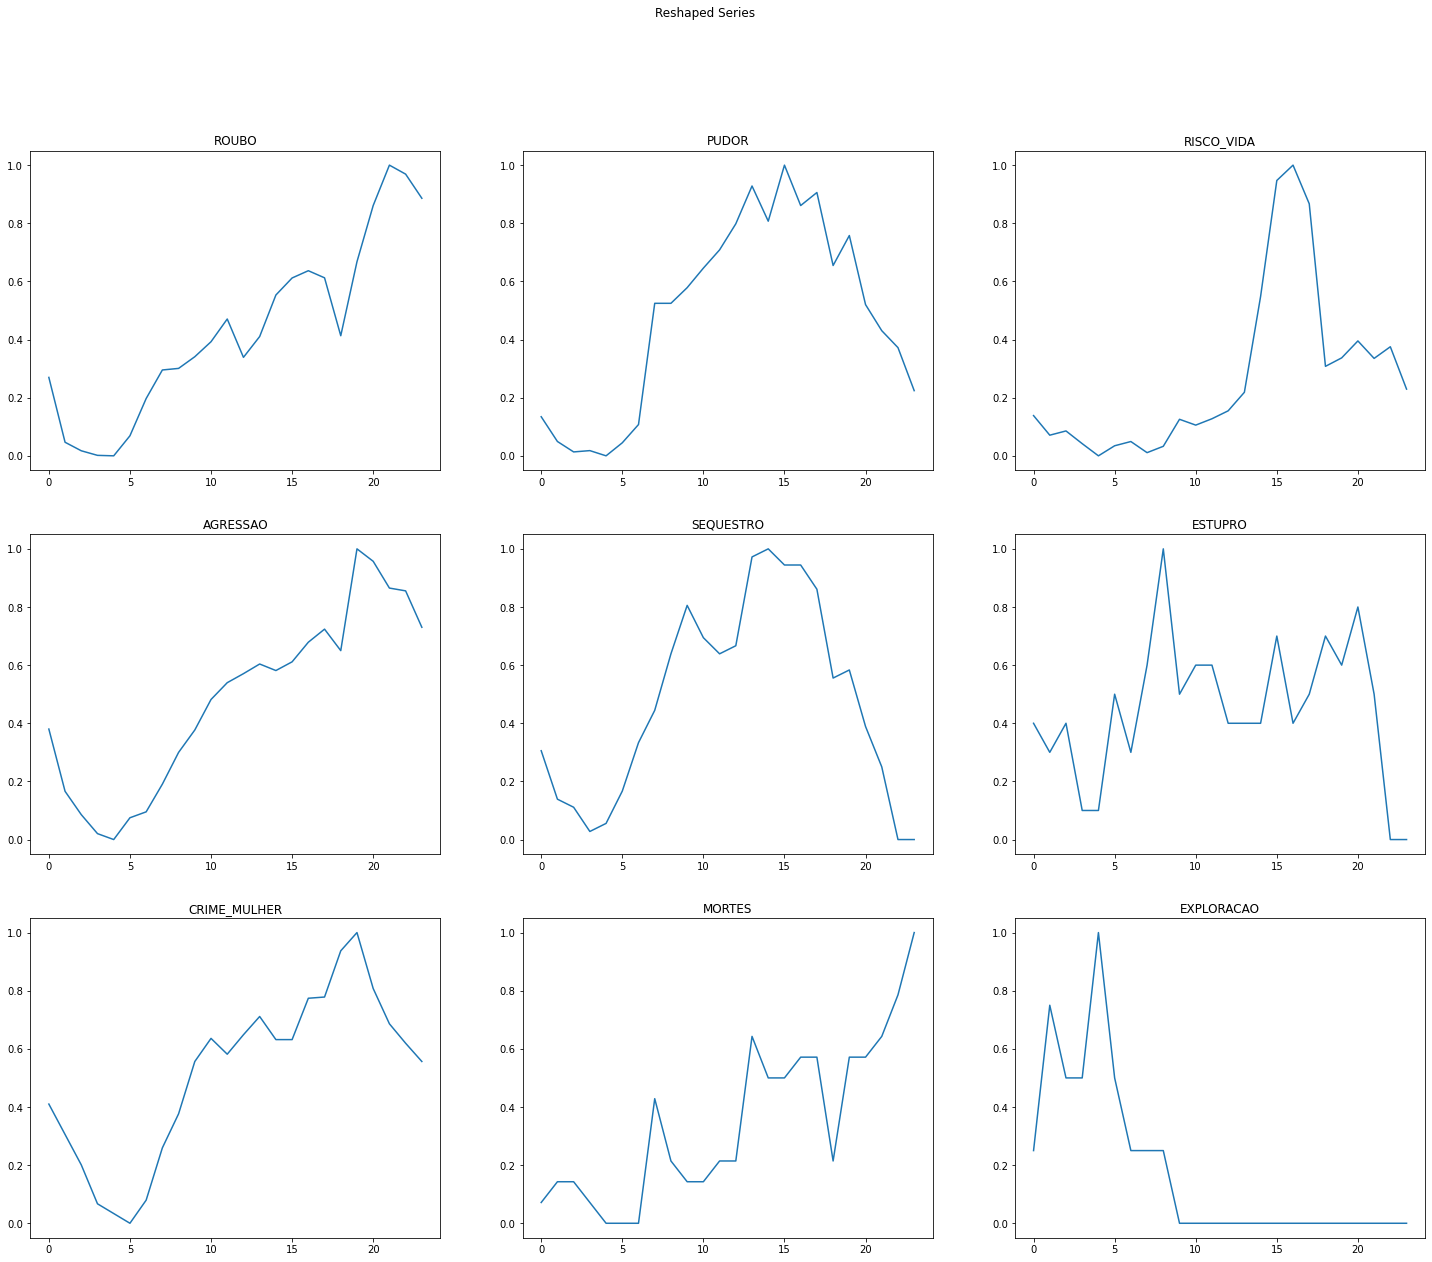

In [12]:
from sklearn.preprocessing import MinMaxScaler

fig, axs = plt.subplots(3,3,figsize=(25,20))
fig.suptitle('Reshaped Series')
for i in range(3):
    for j in range(3):
        if i*3+j+1>len(reshaped_series): # pass the others that we can't fill
            continue
        axs[i, j].plot(MinMaxScaler().fit_transform(reshaped_series[i*3+j]))
        axs[i, j].set_title(crimes[i*3+j])
fig.savefig('images/crimes-normalized.png', dpi=fig.dpi)
plt.show()

In [13]:
for i in range(len(reshaped_series)):
    reshaped_series[i] = MinMaxScaler().fit_transform(reshaped_series[i])
    reshaped_series[i] = reshaped_series[i].flatten()

In [14]:
reshaped_series = np.array(reshaped_series)

Agora todos os crimes possuem mínimo em 0 e máximo em 1

In [15]:
for i in reshaped_series:
    print("max: "+str(max(i))+"\tmin: "+str(min(i)))

max: 1.0	min: 0.0
max: 0.9999999999999999	min: 0.0
max: 1.0	min: 0.0
max: 1.0	min: 0.0
max: 1.0	min: 0.0
max: 1.0	min: 0.0
max: 1.0	min: 0.0
max: 1.0	min: 0.0
max: 1.0	min: 0.0


## Clusterização

In [16]:
from collections import defaultdict
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster, set_link_color_palette
from matplotlib.colors import rgb2hex, colorConverter

In [17]:
reshaped_series.shape

(9, 24)

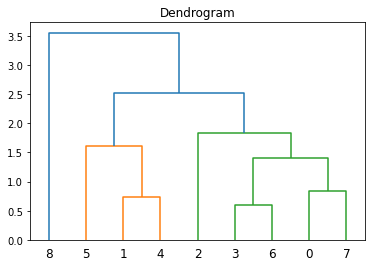

In [18]:
c_dist = pdist(reshaped_series)
c_link = linkage(reshaped_series,  metric='euclidean', method='ward')
dendrogram(c_link)
plt.title('Dendrogram')
fig.savefig('images/clusters.png', dpi=fig.dpi)
plt.show()

Analizando o dendograma, podemos observar que os crimes que ocorrem com uma frequência mais semelhante são os de agressão(3) 
e os crimes contra a mulher(6) aumentando sua frequência por volta das 10:00, atingindo seu pico as 18:00 e caindo no final
do dia essa semelhança poderia ser explicada se os crimes contra a mulher(6) geralmente involve abuso doméstico ou agressões(3).
O segundo grupo de crimes com maior semelhança é o grupo dos crimes de pudor(1) e sequestro(4), começando baixo na madrugada das 00:00 até as 06:00, crescendo com o passar do dia, atingindo o seu pico por volta das 14:00 até as 17:00 e depois caindo 
no final do dia.
O terceiro grupo é o grupo dos roubos(0) e mortes(7) que começa baixo no inicio da madrugada, decaindo depois de um tempo, 
crescendo e tendo alguns picos depois das 06:00 até as 20:00 e por fim tendo um pico máximo no final da noite por volta das 20:00 até as 23:00 esse comportamento é esperado pois esses crimes ocorrem no fim da noite e uma parte dos roubos(0) são assaltos a mão armada, aumentando as chances de morte da vítima. 
O próximo grupo de crimes é grupo do estupro(5) que possui semelhanças com o segundo grupo, começando baixo no inicio da madrugada, tendo vários picos das 07:00 até as 20:00, sendo o seu pico máximo as 8:00 e depois caindo no final do dia esses tipos de crimes também incluem crimes violentos contra o pudor e por isso possui alguma semelhança com esse grupo, porém tendo um número menor de casos. 
Por fim temos o outlier que é o grupo dos crimes de exploração(8) que crescem durante a madrugada, tendo seu pico às 04:00, 
caindo depois das 05:00 e não tendo nenhum caso das 08:00 até o fim do dia, esses tipos de crime tem poucos dados registrados e por isso ele fica zerado por grande parte do dia, dificultando verificar a semelhança deste com os demais crimes.
 
